In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from itertools import product
from sklearn.model_selection import StratifiedKFold
import optuna

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
frb_data = pd.read_csv('frb-data.csv')
frb_data['Repeater'] = frb_data['Repeater'].map({'Yes': 1, 'No': 0})
frb_data['Repeater'] = frb_data['Repeater'].fillna(0)
frb_data['Repeater'] = frb_data['Repeater'].astype(int)

In [3]:
# Select numerical columns that are relevant for VAE training
# features = ['Observing_band', 'MJD', 'GL', 'GB', 'SNR', 'DM_SNR', 'DM_SNR_err', 'DM_alig', 'DM_alig_err', 'Flux_density', 
#             'Flux_density_err', 'Width', 'Width_err', 'Freq_high', 'Freq_low', 'Freq_peak', 'Fluence', 'Fluence_err', 'Energy', 
#             'Energy_err', 'Polar_l', 'Polar_l_err', 'Polar_c', 'Polar_c_err', 'RM_syn', 'RM_syn_err', 'RM_QUfit', 'RM_QUfit_err', 'Scatt_t', 'Scatt_t_err', 'Scin_f', 'Scin_f_err',]

labels = frb_data['Repeater']

# Function to clean numerical strings and convert to float
def clean_numeric_value(value):
    if isinstance(value, str):
        value = value.strip()
        if not value:
            return np.nan
        try:
            # Remove special characters and split if necessary
            for char in ['/', '+', '<', '>', '~']:
                value = value.replace(char, '')
            if '-' in value:
                value = value.split('-')[0]
            return float(value)
        except ValueError:
            return np.nan
    try:
        return float(value)
    except (ValueError, TypeError):
        return np.nan
    
error_features = [
    'DM_SNR', 'DM_alig', 'Flux_density', 'Width', 'Fluence', 'Energy',
    'Polar_l', 'Polar_c', 'RM_syn', 'RM_QUfit', 'Scatt_t', 'Scin_f'
]
base_features = [
    'Observing_band', 'MJD', 'GL', 'GB', 'SNR', 'Freq_high',
    'Freq_low', 'Freq_peak', 'Repeater'
]

for feature in base_features + error_features:
    frb_data[feature] = frb_data[feature].apply(clean_numeric_value)

for feature in error_features:
    frb_data[f'{feature}_err'] = frb_data[f'{feature}_err'].apply(clean_numeric_value)

for feature in error_features:
    frb_data[f'{feature}_upper'] = frb_data[feature] + frb_data[f'{feature}_err']
    frb_data[f'{feature}_lower'] = frb_data[feature] - frb_data[f'{feature}_err']
    frb_data[f'{feature}_lower'] = frb_data[f'{feature}_lower'].clip(lower=0)

features = (
    base_features +
    error_features +
    [f'{feature}_upper' for feature in error_features] +
    [f'{feature}_lower' for feature in error_features]
)

In [4]:
frb_data_clean = frb_data[features].fillna(0)
scaler = StandardScaler()
frb_data_scaled = scaler.fit_transform(frb_data_clean)

# Retain the original indices
indices = frb_data_clean.index

# Split the data and retain indices
train_data, val_data, train_labels, val_labels, train_indices, val_indices = train_test_split(
    frb_data_scaled, labels, indices, test_size=0.2, random_state=42, stratify=labels
)

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 64
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [5]:
class SupervisedVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.3, activation=nn.LeakyReLU(0.1)):
        super(SupervisedVAE, self).__init__()
        
        self.activation = activation
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate)
        )
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, input_dim)
        )
        
        # Classification head for binary classification
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        class_prob = self.classifier(z)
        return recon_x, mu, logvar, class_prob

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = frb_data_scaled.shape[1]
hidden_dim = 256
latent_dim = 10
patience = 4
num_epochs = 150

In [7]:
reconstruction_loss_fn = nn.MSELoss(reduction='sum')
classification_loss_fn = nn.BCELoss()

def loss_function(recon_x, x, mu, logvar, class_prob, labels, beta, gamma):
    recon_loss = reconstruction_loss_fn(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    class_loss = classification_loss_fn(class_prob, labels.unsqueeze(1).float())
    total_loss = recon_loss + beta * kl_loss + gamma * class_loss
    return total_loss, recon_loss, kl_loss, class_loss



In [8]:
def train_supervised(model, optimizer, scheduler, epoch, beta, gamma):
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    
    correct = 0
    total = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, class_logits = model(data)
        
        # Supervised loss function
        loss, recon_loss, kl_loss, classification_loss = loss_function(
            recon_batch, data, mu, logvar, class_logits, labels, beta, gamma
        )
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()
        classification_loss_total += classification_loss.item()
        
        predicted = (class_logits > 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()
        
        # if batch_idx % 100 == 0:
        #     print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
        #           f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon = recon_loss_total / len(train_loader.dataset)
    avg_kl = kl_loss_total / len(train_loader.dataset)
    avg_class = classification_loss_total / len(train_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy

def validate_supervised(model, scheduler, optimizer, epoch, beta, gamma):
    model.eval()
    val_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            recon_batch, mu, logvar, class_logits = model(data)
            
            loss, recon_loss, kl_loss, classification_loss = loss_function(
                recon_batch, data, mu, logvar, class_logits, labels, beta, gamma
            )
            
            val_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()
            classification_loss_total += classification_loss.item()
            
            predicted = (class_logits > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    
    avg_loss = val_loss / len(val_loader.dataset)
    avg_recon = recon_loss_total / len(val_loader.dataset)
    avg_kl = kl_loss_total / len(val_loader.dataset)
    avg_class = classification_loss_total / len(val_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Validation loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy


def early_stopping(val_losses, patience):
    if len(val_losses) > patience:
        if all(val_losses[-i-1] <= val_losses[-i] for i in range(1, patience+1)):
            return True
    return False



In [10]:
def evaluate_classifier(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    false_positives = np.sum((all_labels == 0) & (all_preds == 1))

    return accuracy, class_report, conf_matrix, f1, false_positives  # Return F1 score as well

def get_activation_function(name):
    if name == 'ReLU':
        return nn.ReLU()
    elif name == 'LeakyReLU':
        return nn.LeakyReLU(0.1)
    elif name == 'ELU':
        return nn.ELU()
    elif name == 'SELU':
        return nn.SELU()
    elif name == 'GELU':
        return nn.GELU()
    else:
        raise ValueError(f"Unknown activation function: {name}")

In [ ]:


def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 128, 512)
    latent_dim = trial.suggest_int('latent_dim', 5, 20)
    beta = trial.suggest_float('beta', 0.5, 2.0)
    gamma = trial.suggest_float('gamma', 0.5, 2.0)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    activation_name = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'ELU', 'SELU', 'GELU'])
    activation = get_activation_function(activation_name)

    model = SupervisedVAE(input_dim, hidden_dim, latent_dim, dropout_rate, activation).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)
    
    for epoch in range(1, 40):  # Use a smaller number of epochs for faster optimization
        train_loss, _, _, _, _ = train_supervised(model, optimizer, scheduler, epoch, beta, gamma)
        val_loss, _, _, _, val_accuracy = validate_supervised(model, optimizer, scheduler, epoch, beta, gamma)
        scheduler.step(val_loss)
    
    # Evaluate model performance
    val_accuracy, _, _, val_f1_score, val_false_positives = evaluate_classifier(model, val_loader, device)
    
    min_false_positives = 7
    
    if val_false_positives < min_false_positives:
        penalty = (min_false_positives - val_false_positives) * 0.03
        return val_accuracy - penalty
    else:
        return val_accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best Hyperparameters:", study.best_params)

### my computer restarted so I lost the actual study, here was original output from github save

[I 2024-11-08 11:06:47,843] A new study created in memory with name: no-name-35ca2c54-cb96-48b6-a30f-e2817e6b08c1
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-11-08 11:07:04,225] Trial 0 finished with value: 0.9388343912290825 and parameters: {'hidden_dim': 155, 'latent_dim': 20, 'beta': 0.9371323291832163, 'gamma': 1.4718094542355709, 'dropout_rate': 0.4460749445644837, 'activation': 'ReLU'}. Best is trial 0 with value: 0.9388343912290825.
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-11-08 11:07:18,889] Trial 1 finished with value: 0.9555683785343335 and parameters: {'hidden_dim': 135, 'latent_dim': 14, 'beta': 1.257829754757752, 'gamma': 1.3827302884848554, 'dropout_rate': 0.2070199260102121, 'activation': 'ELU'}. Best is trial 1 with value: 0.9555683785343335.
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-11-08 11:07:33,784] Trial 2 finished with value: 0.9180611656087709 and parameters: {'hidden_dim': 421, 'latent_dim': 11, 'beta': 1.8929665662812574, 'gamma': 1.4233541891118782, 'dropout_rate': 0.4508026295479287, 'activation': 'SELU'}. Best is trial 1 with value: 0.9555683785343335.
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-11-08 11:07:47,525] Trial 3 finished with value: 0.9272937103289094 and parameters: {'hidden_dim': 210, 'latent_dim': 5, 'beta': 1.9421097302870607, 'gamma': 1.7061665080529875, 'dropout_rate': 0.4270233022738861, 'activation': 'ELU'}. Best is trial 1 with value: 0.9555683785343335.
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-11-08 11:08:02,374] Trial 4 finished with value: 0.9809578765147143 and parameters: {'hidden_dim': 452, 'latent_dim': 8, 'beta': 0.8350239577336085, 'gamma': 0.6676288034192681, 'dropout_rate': 0.22203835191132928, 'activation': 'SELU'}. Best is trial 4 with value: 0.9809578765147143.
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-11-08 11:08:16,661] Trial 5 finished with value: 0.9757645701096365 and parameters: {'hidden_dim': 322, 'latent_dim': 16, 'beta': 0.5219126301041226, 'gamma': 1.2470281839448252, 'dropout_rate': 0.44651425107355625, 'activation': 'LeakyReLU'}. Best is trial 4 with value: 0.9809578765147143.
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-11-08 11:08:31,749] Trial 6 finished with value: 0.9572994806693594 and parameters: {'hidden_dim': 476, 'latent_dim': 19, 'beta': 1.1591732250720452, 'gamma': 0.8356122295875926, 'dropout_rate': 0.40181734759860643, 'activation': 'LeakyReLU'}. Best is trial 4 with value: 0.9809578765147143.
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-11-08 11:08:46,958] Trial 7 finished with value: 0.9896133871898442 and parameters: {'hidden_dim': 442, 'latent_dim': 10, 'beta': 0.5438633490481534, 'gamma': 1.733924516790239, 'dropout_rate': 0.2997195135988838, 'activation': 'LeakyReLU'}. Best is trial 7 with value: 0.9896133871898442.
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-11-08 11:09:02,069] Trial 8 finished with value: 0.9705712637045586 and parameters: {'hidden_dim': 377, 'latent_dim': 20, 'beta': 0.9957593858927356, 'gamma': 1.0181988305138399, 'dropout_rate': 0.14122208624241403, 'activation': 'LeakyReLU'}. Best is trial 7 with value: 0.9896133871898442.
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-11-08 11:09:16,911] Trial 9 finished with value: 0.9809578765147143 and parameters: {'hidden_dim': 420, 'latent_dim': 7, 'beta': 0.7777458072157469, 'gamma': 0.7240870231338, 'dropout_rate': 0.15906541345029837, 'activation': 'SELU'}. Best is trial 7 with value: 0.9896133871898442.
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-11-08 11:09:31,493] Trial 10 finished with value: 0.953260242354299 and parameters: {'hidden_dim': 277, 'latent_dim': 11, 'beta': 1.570928184979122, 'gamma': 1.8491502804153352, 'dropout_rate': 0.3337195045953603, 'activation': 'GELU'}. Best is trial 7 with value: 0.9896133871898442.
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-11-08 11:09:45,455] Trial 11 finished with value: 0.9890363531448355 and parameters: {'hidden_dim': 512, 'latent_dim': 8, 'beta': 0.5201972640563551, 'gamma': 0.5090517291878291, 'dropout_rate': 0.26765437466104336, 'activation': 'SELU'}. Best is trial 7 with value: 0.9896133871898442.
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-11-08 11:09:59,779] Trial 12 finished with value: 0.9896133871898442 and parameters: {'hidden_dim': 369, 'latent_dim': 9, 'beta': 0.5291656338691898, 'gamma': 1.9948530346990063, 'dropout_rate': 0.2993425628821488, 'activation': 'GELU'}. Best is trial 7 with value: 0.9896133871898442.
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-11-08 11:10:14,310] Trial 13 finished with value: 0.979803808424697 and parameters: {'hidden_dim': 350, 'latent_dim': 10, 'beta': 0.6513995558219048, 'gamma': 1.9355996956209132, 'dropout_rate': 0.33816389646310396, 'activation': 'GELU'}. Best is trial 7 with value: 0.9896133871898442.
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-11-08 11:10:28,581] Trial 14 finished with value: 0.944604731679169 and parameters: {'hidden_dim': 293, 'latent_dim': 14, 'beta': 1.3880468321872956, 'gamma': 1.668370605534986, 'dropout_rate': 0.2889296120626597, 'activation': 'GELU'}. Best is trial 7 with value: 0.9896133871898442.
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-11-08 11:10:42,747] Trial 15 finished with value: 0.9774956722446624 and parameters: {'hidden_dim': 388, 'latent_dim': 5, 'beta': 0.6348234048653665, 'gamma': 1.947264818240976, 'dropout_rate': 0.3637426736513705, 'activation': 'ReLU'}. Best is trial 7 with value: 0.9896133871898442.
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-11-08 11:10:57,158] Trial 16 finished with value: 0.9671090594345066 and parameters: {'hidden_dim': 240, 'latent_dim': 9, 'beta': 1.0424381445924, 'gamma': 1.6686718546353605, 'dropout_rate': 0.24667189570355663, 'activation': 'LeakyReLU'}. Best is trial 7 with value: 0.9896133871898442.
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-11-08 11:11:11,663] Trial 17 finished with value: 0.9694171956145412 and parameters: {'hidden_dim': 353, 'latent_dim': 13, 'beta': 0.7486618828512746, 'gamma': 1.8057326078022706, 'dropout_rate': 0.49710990912694697, 'activation': 'GELU'}. Best is trial 7 with value: 0.9896133871898442.
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-11-08 11:11:26,226] Trial 18 finished with value: 0.9555683785343335 and parameters: {'hidden_dim': 504, 'latent_dim': 16, 'beta': 1.5818706845843544, 'gamma': 1.9954263974676392, 'dropout_rate': 0.3096322717142831, 'activation': 'GELU'}. Best is trial 7 with value: 0.9896133871898442.
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-11-08 11:11:40,288] Trial 19 finished with value: 0.9901904212348529 and parameters: {'hidden_dim': 424, 'latent_dim': 7, 'beta': 0.5067400241203814, 'gamma': 1.148982993254297, 'dropout_rate': 0.10407527918620693, 'activation': 'LeakyReLU'}. Best is trial 19 with value: 0.9901904212348529.

In [15]:
best_params = study.best_params

beta = best_params["beta"]
gamma = best_params["gamma"]
num_epochs = 150
patience = 4

best_params

{'hidden_dim': 424,
 'latent_dim': 7,
 'beta': 0.5067400241203814,
 'gamma': 1.148982993254297,
 'dropout_rate': 0.10407527918620693,
 'activation': 'LeakyReLU'}

###  use the results above

In [15]:
best_params = {'hidden_dim': 424,
 'latent_dim': 7,
 'beta': 0.5067400241203814,
 'gamma': 1.148982993254297,
 'dropout_rate': 0.10407527918620693,
 'activation': 'LeakyReLU'}

beta = best_params["beta"]
gamma = best_params["gamma"]
num_epochs = 150
patience = 4


In [16]:
best_model = SupervisedVAE(input_dim, best_params["hidden_dim"], best_params["latent_dim"], best_params["dropout_rate"], activation=get_activation_function(best_params["activation"])).to(device)
optimizer = torch.optim.Adam(best_model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)

New best model saved with validation loss: 19.6255
New best model saved with validation accuracy: 0.9608
New best model saved with validation loss: 17.1783
New best model saved with validation accuracy: 0.9683
New best model saved with validation loss: 14.7690
New best model saved with validation accuracy: 0.9700
New best model saved with validation loss: 14.6022
New best model saved with validation accuracy: 0.9804
New best model saved with validation loss: 12.3041
New best model saved with validation accuracy: 0.9815
New best model saved with validation loss: 12.1502
New best model saved with validation accuracy: 0.9838
New best model saved with validation loss: 12.0722
New best model saved with validation accuracy: 0.9902
New best model saved with validation loss: 11.3695
New best model saved with validation accuracy: 0.9913
New best model saved with validation loss: 10.6320
New best model saved with validation accuracy: 0.9942
New best model saved with validation loss: 10.3840
New 

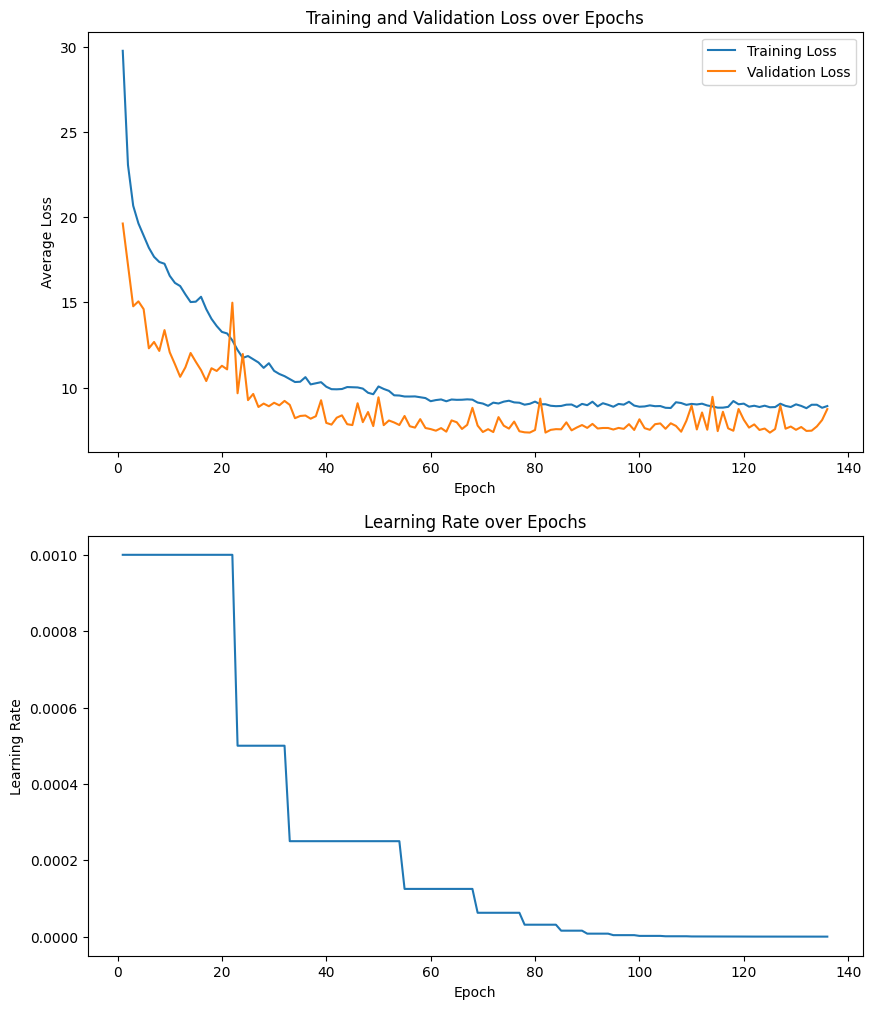

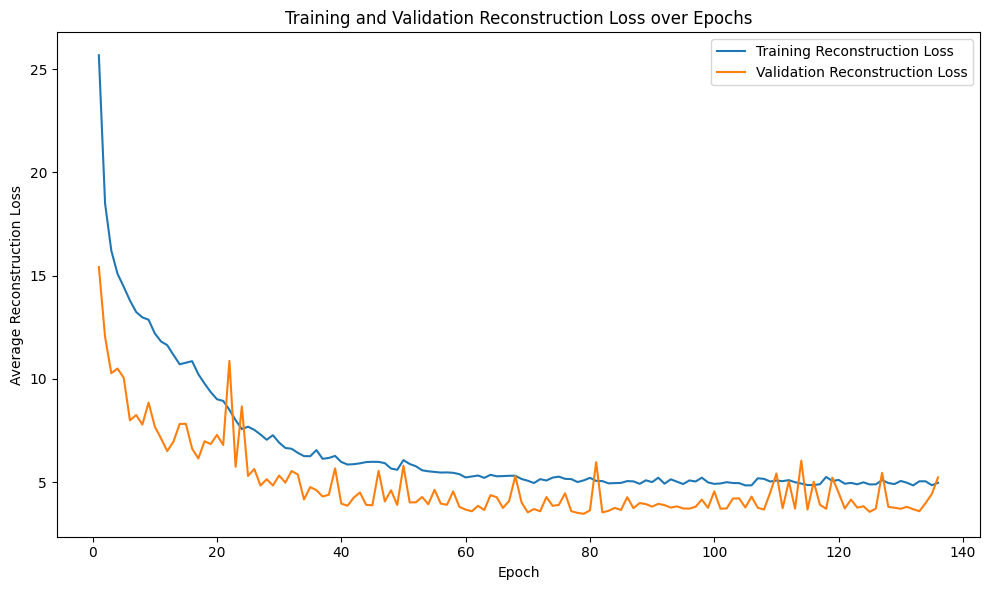

In [17]:
best_train_losses = []
best_val_losses = []
best_train_recon_losses = []
best_val_recon_losses = []
best_train_kl_losses = []
best_val_kl_losses = []
best_train_class_losses = []
best_val_class_losses = []
best_val_accuracies = []
best_learning_rates = []

best_best_loss = float('inf')
best_best_val_accuracy = 0


for epoch in range(1, num_epochs + 1):
    # Training step
    train_loss, train_recon, train_kl, train_class, train_accuracy = train_supervised(best_model, optimizer, scheduler, epoch, beta, gamma)
    
    # Validation step
    val_loss, val_recon, val_kl, val_class, val_accuracy = validate_supervised(best_model, optimizer, scheduler, epoch, beta, gamma)
    
    # Track losses and accuracy
    best_train_losses.append(train_loss)
    best_val_losses.append(val_loss)
    best_train_recon_losses.append(train_recon)
    best_val_recon_losses.append(val_recon)
    best_train_kl_losses.append(train_kl)
    best_val_kl_losses.append(val_kl)
    best_train_class_losses.append(train_class)
    best_val_class_losses.append(val_class)
    best_val_accuracies.append(val_accuracy)
    best_learning_rates.append(optimizer.param_groups[0]['lr'])
    
    # Scheduler step
    scheduler.step(val_loss)

    # Save the best model based on validation loss
    if val_loss < best_best_loss:
        best_best_loss = val_loss
        torch.save(best_model.state_dict(), 'best_supervised_vae_best_loss.pth')
        print(f"New best model saved with validation loss: {best_best_loss:.4f}")
    
    # Save the best model based on validation accuracy
    if val_accuracy > best_best_val_accuracy:
        best_best_val_accuracy = val_accuracy
        torch.save(best_model.state_dict(), 'best_supervised_vae_best_acc.pth')
        print(f"New best model saved with validation accuracy: {best_best_val_accuracy:.4f}")
    
    # Early stopping
    if early_stopping(best_val_losses, patience):
        print(f"Early stopping triggered at epoch {epoch}")
        break
    

print("Training complete.")

# Plot training and validation loss, learning rates, and reconstruction loss
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot training and validation loss
ax1.plot(range(1, len(best_train_losses) + 1), best_train_losses, label='Training Loss')
ax1.plot(range(1, len(best_val_losses) + 1), best_val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Loss')
ax1.legend()

# Plot learning rate
ax2.plot(range(1, len(best_learning_rates) + 1), best_learning_rates)
ax2.set_title('Learning Rate over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate')

# Plot the training and validation reconstruction loss
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(1, len(best_train_recon_losses) + 1), best_train_recon_losses, label='Training Reconstruction Loss')
ax.plot(range(1, len(best_val_recon_losses) + 1), best_val_recon_losses, label='Validation Reconstruction Loss')
ax.set_title('Training and Validation Reconstruction Loss over Epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Average Reconstruction Loss')
ax.legend()

plt.tight_layout()
plt.show()


In [18]:
val_accuracy, val_class_report, val_conf_matrix, val_f1_score, fp = evaluate_classifier(best_model, val_loader, device)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", val_class_report)
print("Confusion Matrix:\n", val_conf_matrix)
print(f"Validation F1 Score: {val_f1_score:.4f}")

Validation Accuracy: 0.9919
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       238
    Repeater       1.00      1.00      1.00      1495

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 231    7]
 [   7 1488]]
Validation F1 Score: 0.9919


In [19]:
def evaluate_classifier_full(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return accuracy, class_report, conf_matrix, all_preds, all_labels

In [20]:
garcia_list = '''
FRB20180907E
FRB20180920B
FRB20180928A
FRB20181017B
FRB20181022E
FRB20181125A
FRB20181125A
FRB20181125A
FRB20181214A
FRB20181220A
FRB20181226E
FRB20181229B
FRB20190112A
FRB20190128C
FRB20190206B
FRB20190206A
FRB20190218B
FRB20190223A
FRB20190308C
FRB20190308C
FRB20190323D
FRB20190329A
FRB20190410A
FRB20190412B
FRB20190423B
FRB20190423B
FRB20190429B
FRB20190430A
FRB20190527A
FRB20190527A
FRB20190601C
FRB20190601C
FRB20190617B
FRB20180910A
FRB20190210C
FRB20200726D
'''.split()

luo_list = '''
FRB20181229B
FRB20190423B
FRB20190410A
FRB20181017B
FRB20181128C
FRB20190422A
FRB20190409B
FRB20190329A
FRB20190423B
FRB20190206A
FRB20190128C
FRB20190106A
FRB20190129A
FRB20181030E
FRB20190527A
FRB20190218B
FRB20190609A
FRB20190412B
FRB20190125B
FRB20181231B
FRB20181221A
FRB20190112A
FRB20190125A
FRB20181218C
FRB20190429B
FRB20190109B
FRB20190206B
'''.split()

zhu_ge_list = '''
FRB20180911A
FRB20180915B
FRB20180920B
FRB20180923A
FRB20180923C
FRB20180928A
FRB20181013E
FRB20181017B
FRB20181030E
FRB20181125A
FRB20181125A
FRB20181125A
FRB20181130A
FRB20181214A
FRB20181220A
FRB20181221A
FRB20181226E
FRB20181229B
FRB20181231B
FRB20190106B
FRB20190109B
FRB20190110C
FRB20190111A
FRB20190112A
FRB20190129A
FRB20190204A
FRB20190206A
FRB20190218B
FRB20190220A
FRB20190221A
FRB20190222B
FRB20190223A
FRB20190228A
FRB20190308C
FRB20190308C
FRB20190308B
FRB20190308B
FRB20190323D
FRB20190329A
FRB20190403E
FRB20190409B
FRB20190410A
FRB20190412B
FRB20190418A
FRB20190419A
FRB20190422A
FRB20190422A
FRB20190423A
FRB20190423B
FRB20190423B
FRB20190429B
FRB20190430A
FRB20190517C
FRB20190527A
FRB20190527A
FRB20190531C
FRB20190601B
FRB20190601C
FRB20190601C
FRB20190609A
FRB20190617A
FRB20190617B
FRB20190618A
FRB20190625A
'''.split()

In [32]:
val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(best_model, val_loader, device)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", val_class_report)
print("Confusion Matrix:\n", val_conf_matrix)

original_data = pd.read_csv('frb-data.csv')
original_data['Repeater'] = original_data['Repeater'].map({'Yes': 1, 'No': 0}).fillna(0).astype(int)

misclassified_non_repeaters = (val_labels == 0) & (val_preds == 1)
misclassified_indices = val_indices[misclassified_non_repeaters]
misclassified_sources = original_data.loc[misclassified_indices, "Source"].drop_duplicates()



for source in misclassified_sources:
    if source in garcia_list or source in luo_list or source in zhu_ge_list:
        print(source)


Validation Accuracy: 0.9908
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       238
    Repeater       0.99      1.00      0.99      1495

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 229    9]
 [   7 1488]]
FRB20181022E
FRB20181218C


In [221]:
all_false_positives = []
num_epochs = 100

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

full_data_tensor = torch.tensor(frb_data_scaled, dtype=torch.float32)
full_labels_tensor = torch.tensor(labels.values, dtype=torch.long)

for fold, (train_index, val_index) in enumerate(skf.split(frb_data_scaled, labels)):
    print(f"\n=== Fold {fold + 1}/{n_folds} ===")
    
    train_data, val_data = frb_data_scaled[train_index], frb_data_scaled[val_index]
    train_labels, val_labels = labels.iloc[train_index], labels.iloc[val_index]
    
    train_tensor = torch.tensor(train_data, dtype=torch.float32)
    val_tensor = torch.tensor(val_data, dtype=torch.float32)
    train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
    val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)
    
    train_dataset = TensorDataset(train_tensor, train_labels_tensor)
    val_dataset = TensorDataset(val_tensor, val_labels_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    best_model = SupervisedVAE(
        input_dim, 
        best_params["hidden_dim"], 
        best_params["latent_dim"], 
        best_params["dropout_rate"], 
        activation=get_activation_function(best_params["activation"])
    ).to(device)
    
    optimizer = torch.optim.Adam(best_model.parameters(), lr=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)
    
    # Train the model
    for epoch in range(1, num_epochs + 1):
        train_loss, _, _, _, train_accuracy = train_supervised(best_model, optimizer, scheduler, epoch, beta, gamma)
        val_loss, _, _, _, val_accuracy = validate_supervised(best_model, optimizer, scheduler, epoch, beta, gamma)
        scheduler.step(val_loss)
        
        # Early stopping
        if early_stopping([val_loss], patience):
            print(f"Early stopping triggered at epoch {epoch}")
            break

    val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(best_model, val_loader, device)
    
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print("Classification Report:\n", val_class_report)
    print("Confusion Matrix:\n", val_conf_matrix)
    
    misclassified_non_repeaters = (val_labels == 0) & (val_preds == 1)
    misclassified_indices = val_index[misclassified_non_repeaters]
    misclassified_sources = original_data.loc[misclassified_indices, "Source"].drop_duplicates()
    
    fold_false_positives = []
    for source in misclassified_sources:
        fold_false_positives.append(source)
        if source in garcia_list or source in luo_list or source in zhu_ge_list:
            print(f"False positive in fold {fold + 1}: {source}")
            
    
    all_false_positives.extend(fold_false_positives)



=== Fold 1/5 ===


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Validation Accuracy: 0.9908
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       238
    Repeater       0.99      1.00      0.99      1495

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 228   10]
 [   6 1489]]

=== Fold 2/5 ===


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.98       238
    Repeater       1.00      1.00      1.00      1495

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 231    7]
 [   4 1491]]
False positive in fold 2: FRB20190106A
False positive in fold 2: FRB20190617B

=== Fold 3/5 ===


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.97      0.98       238
    Repeater       0.99      1.00      1.00      1495

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 230    8]
 [   3 1492]]

=== Fold 4/5 ===


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Validation Accuracy: 0.9885
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.95      0.96       239
    Repeater       0.99      0.99      0.99      1494

    accuracy                           0.99      1733
   macro avg       0.98      0.97      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 228   11]
 [   9 1485]]

=== Fold 5/5 ===


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Validation Accuracy: 0.9856
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.93      0.95       238
    Repeater       0.99      0.99      0.99      1494

    accuracy                           0.99      1732
   macro avg       0.98      0.96      0.97      1732
weighted avg       0.99      0.99      0.99      1732

Confusion Matrix:
 [[ 221   17]
 [   8 1486]]


In [225]:
all_false_positives = list(set(all_false_positives)) # drop duplicates

print(len(all_false_positives))

for source in all_false_positives:
    if source in garcia_list or source in luo_list or source in zhu_ge_list:
        print(source)

47
FRB20190106A
FRB20190617B


## Training each fold separately

In [33]:
all_false_positives = []
num_epochs = 100
n_folds = 5

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

full_data_tensor = torch.tensor(frb_data_scaled, dtype=torch.float32)
full_labels_tensor = torch.tensor(labels.values, dtype=torch.long)


In [34]:
# === Fold 1 Training ===

fold = 0
train_index, val_index = list(skf.split(frb_data_scaled, labels))[fold]

train_data, val_data = frb_data_scaled[train_index], frb_data_scaled[val_index]
train_labels, val_labels = labels.iloc[train_index], labels.iloc[val_index]

train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


fold_model_1 = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

optimizer = torch.optim.Adam(fold_model_1.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)

# Train the model
for epoch in range(1, num_epochs + 1):
    train_loss, _, _, _, train_accuracy = train_supervised(fold_model_1, optimizer, scheduler, epoch, beta, gamma)
    val_loss, _, _, _, val_accuracy = validate_supervised(fold_model_1, optimizer, scheduler, epoch, beta, gamma)
    scheduler.step(val_loss)
    
    # Early stopping
    if early_stopping([val_loss], patience):
        print(f"Early stopping triggered at epoch {epoch}")
        break


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [151]:
# === Fold 1 Evaluation ===
val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(fold_model_1, val_loader, device)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", val_class_report)
print("Confusion Matrix:\n", val_conf_matrix)

misclassified_non_repeaters = (val_labels == 0) & (val_preds == 1)
misclassified_indices = val_index[misclassified_non_repeaters]
misclassified_sources = original_data.loc[misclassified_indices, "Source"].drop_duplicates()

fold_1_false_positives = []
for source in misclassified_sources:
    fold_1_false_positives.append(source)
    if source in garcia_list or source in luo_list or source in zhu_ge_list:
        print(f"False positive in fold {fold + 1}: {source}")

Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.97      0.98       238
    Repeater       1.00      1.00      1.00      1494

    accuracy                           0.99      1732
   macro avg       0.99      0.98      0.99      1732
weighted avg       0.99      0.99      0.99      1732

Confusion Matrix:
 [[ 231    7]
 [   3 1491]]


In [86]:
# === Fold 2 Training ===

fold = 1
train_index, val_index = list(skf.split(frb_data_scaled, labels))[fold]

train_data, val_data = frb_data_scaled[train_index], frb_data_scaled[val_index]
train_labels, val_labels = labels.iloc[train_index], labels.iloc[val_index]

train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


fold_model_2 = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

optimizer = torch.optim.Adam(fold_model_2.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)

# Train the model
for epoch in range(1, num_epochs + 1):
    train_loss, _, _, _, train_accuracy = train_supervised(fold_model_2, optimizer, scheduler, epoch, beta, gamma)
    val_loss, _, _, _, val_accuracy = validate_supervised(fold_model_2, optimizer, scheduler, epoch, beta, gamma)
    scheduler.step(val_loss)
    
    # Early stopping
    if early_stopping([val_loss], patience):
        print(f"Early stopping triggered at epoch {epoch}")
        break

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [93]:
# === Fold 2 Evaluation ===
val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(fold_model_2, val_loader, device)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", val_class_report)
print("Confusion Matrix:\n", val_conf_matrix)

misclassified_non_repeaters = (val_labels == 0) & (val_preds == 1)
misclassified_indices = val_index[misclassified_non_repeaters]
misclassified_sources = original_data.loc[misclassified_indices, "Source"].drop_duplicates()

fold_2_false_positives = []
for source in misclassified_sources:
    fold_2_false_positives.append(source)
    if source in garcia_list or source in luo_list or source in zhu_ge_list:
        print(f"False positive in fold {fold + 1}: {source}")

Validation Accuracy: 0.9885
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       1.00      0.92      0.96       238
    Repeater       0.99      1.00      0.99      1495

    accuracy                           0.99      1733
   macro avg       0.99      0.96      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 219   19]
 [   1 1494]]
False positive in fold 2: FRB20190418A
False positive in fold 2: FRB20181220A
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20181214A
False positive in fold 2: FRB20190617B


In [94]:
# === Fold 3 Training ===

fold = 2
train_index, val_index = list(skf.split(frb_data_scaled, labels))[fold]

train_data, val_data = frb_data_scaled[train_index], frb_data_scaled[val_index]
train_labels, val_labels = labels.iloc[train_index], labels.iloc[val_index]

train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


fold_model_3 = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

optimizer = torch.optim.Adam(fold_model_3.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)

# Train the model
for epoch in range(1, num_epochs + 1):
    train_loss, _, _, _, train_accuracy = train_supervised(fold_model_3, optimizer, scheduler, epoch, beta, gamma)
    val_loss, _, _, _, val_accuracy = validate_supervised(fold_model_3, optimizer, scheduler, epoch, beta, gamma)
    scheduler.step(val_loss)
    
    # Early stopping
    if early_stopping([val_loss], patience):
        print(f"Early stopping triggered at epoch {epoch}")
        break

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [142]:
# === Fold 3 Evaluation ===
val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(fold_model_3, val_loader, device)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", val_class_report)
print("Confusion Matrix:\n", val_conf_matrix)

misclassified_non_repeaters = (val_labels == 0) & (val_preds == 1)
misclassified_indices = val_index[misclassified_non_repeaters]
misclassified_sources = original_data.loc[misclassified_indices, "Source"].drop_duplicates()

fold_3_false_positives = []
for source in misclassified_sources:
    fold_3_false_positives.append(source)
    if source in garcia_list or source in luo_list or source in zhu_ge_list:
        print(f"False positive in fold {fold + 1}: {source}")

Validation Accuracy: 0.9919
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       238
    Repeater       0.99      1.00      1.00      1494

    accuracy                           0.99      1732
   macro avg       0.98      0.98      0.98      1732
weighted avg       0.99      0.99      0.99      1732

Confusion Matrix:
 [[ 230    8]
 [   6 1488]]


In [101]:
# === Fold 4 Training ===

fold = 3
train_index, val_index = list(skf.split(frb_data_scaled, labels))[fold]

train_data, val_data = frb_data_scaled[train_index], frb_data_scaled[val_index]
train_labels, val_labels = labels.iloc[train_index], labels.iloc[val_index]

train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


fold_model_4 = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

optimizer = torch.optim.Adam(fold_model_4.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)

# Train the model
for epoch in range(1, num_epochs + 1):
    train_loss, _, _, _, train_accuracy = train_supervised(fold_model_4, optimizer, scheduler, epoch, beta, gamma)
    val_loss, _, _, _, val_accuracy = validate_supervised(fold_model_4, optimizer, scheduler, epoch, beta, gamma)
    scheduler.step(val_loss)
    
    # Early stopping
    if early_stopping([val_loss], patience):
        print(f"Early stopping triggered at epoch {epoch}")
        break

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [120]:
# === Fold 4 Evaluation ===
val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(fold_model_4, val_loader, device)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", val_class_report)
print("Confusion Matrix:\n", val_conf_matrix)

misclassified_non_repeaters = (val_labels == 0) & (val_preds == 1)
misclassified_indices = val_index[misclassified_non_repeaters]
misclassified_sources = original_data.loc[misclassified_indices, "Source"].drop_duplicates()

fold_4_false_positives = []
for source in misclassified_sources:
    fold_4_false_positives.append(source)
    if source in garcia_list or source in luo_list or source in zhu_ge_list:
        print(f"False positive in fold {fold + 1}: {source}")

Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.96      0.98       239
    Repeater       0.99      1.00      1.00      1494

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 230    9]
 [   2 1492]]
False positive in fold 4: FRB20190625A


In [121]:
# === Fold 5 Training ===

fold = 4
train_index, val_index = list(skf.split(frb_data_scaled, labels))[fold]

train_data, val_data = frb_data_scaled[train_index], frb_data_scaled[val_index]
train_labels, val_labels = labels.iloc[train_index], labels.iloc[val_index]

train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


fold_model_5 = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

optimizer = torch.optim.Adam(fold_model_5.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)

# Train the model
for epoch in range(1, num_epochs + 1):
    train_loss, _, _, _, train_accuracy = train_supervised(fold_model_5, optimizer, scheduler, epoch, beta, gamma)
    val_loss, _, _, _, val_accuracy = validate_supervised(fold_model_5, optimizer, scheduler, epoch, beta, gamma)
    scheduler.step(val_loss)
    
    # Early stopping
    if early_stopping([val_loss], patience):
        print(f"Early stopping triggered at epoch {epoch}")
        break

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [195]:
# === Fold 4 Evaluation ===
val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(fold_model_5, val_loader, device)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", val_class_report)
print("Confusion Matrix:\n", val_conf_matrix)

misclassified_non_repeaters = (val_labels == 0) & (val_preds == 1)
misclassified_indices = val_index[misclassified_non_repeaters]
misclassified_sources = original_data.loc[misclassified_indices, "Source"].drop_duplicates()

fold_5_false_positives = []
for source in misclassified_sources:
    fold_5_false_positives.append(source)
    if source in garcia_list or source in luo_list or source in zhu_ge_list:
        print(f"False positive in fold {fold + 1}: {source}")

Validation Accuracy: 0.9913
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       238
    Repeater       1.00      0.99      0.99      1494

    accuracy                           0.99      1732
   macro avg       0.98      0.98      0.98      1732
weighted avg       0.99      0.99      0.99      1732

Confusion Matrix:
 [[ 231    7]
 [   8 1486]]
False positive in fold 5: FRB20190410A


In [196]:
individual_false_positives = fold_1_false_positives + fold_2_false_positives + fold_3_false_positives + fold_4_false_positives + fold_5_false_positives
individual_false_positives = list(set(individual_false_positives))

print(len(individual_false_positives))

for source in individual_false_positives:
    if source in garcia_list or source in luo_list or source in zhu_ge_list:
        print(source)

41
FRB20190625A
FRB20181214A
FRB20190423B
FRB20190418A
FRB20190410A
FRB20190617B
FRB20181220A


In [155]:
for source in individual_false_positives:
        print(source)

FRB20170606A
FRB20170922A
FRB20180309A
FRB20190102C
FRB20191108A
FRB20190608B
FRB20190601C
FRB20180923B
FRB20180130A
FRB20190316A
FRB20220506D
FRB20180311A
FRB20190104A
FRB20190625A
FRB20220207C
FRB20151018A
FRB20220914A
FRB20210408H
FRB20181214A
FRB20220912A
FRB20160608A
FRB20240215A
FRB20190423B
FRB20190418A
FRB20220105A
FRB20220726A
FRB20190926B
FRB20221101A
FRB20221101B
FRB20010702C
FRB20190630B
FRB20110220A
FRB20240119A
FRB20221027A
FRB20181219C
FRB20171020A
FRB20190617B
FRB20170712A
FRB20110523A
FRB20190806B
FRB20220926A
FRB20181220A
